# SmoothQuant on Llama 2 7B

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn
from transformers.models.llama.modeling_llama import LlamaForCausalLM

from transformers import LlamaTokenizer
from smoothquant.smooth import smooth_lm
from smoothquant.fake_quant import quantize_llama_like
import tqdm

The following is an evaluator to see the performance of the model. We use a toy dataset (the first 40 examples in the test set of the Wikitext-2 dataset) to evaluate the model. You can replace it with your own dataset. The conclusion should be the same.

In [2]:
class Evaluator:
    def __init__(self, dataset, tokenizer, device, n_samples=40):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.device = device

        self.dataset = tokenizer(
            "\n\n".join(dataset["text"]), return_tensors="pt"
        ).input_ids.to(device)

        self.n_samples = n_samples

    @torch.no_grad()
    def evaluate(self, model):
        model.eval()
        nlls = []
        for i in tqdm.tqdm(range(self.n_samples), desc="Evaluating..."):
            batch = self.dataset[:, (i * 2048) : ((i + 1) * 2048)].to(model.device)
            with torch.no_grad():
                lm_logits = model(batch).logits
            shift_logits = lm_logits[:, :-1, :].contiguous().float()
            shift_labels = self.dataset[:, (i * 2048) : ((i + 1) * 2048)][:, 1:]
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(
                shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1)
            )
            neg_log_likelihood = loss.float() * 2048
            nlls.append(neg_log_likelihood)

        return torch.exp(torch.stack(nlls).sum() / (self.n_samples * 2048))

In [3]:
from datasets import load_dataset

tokenizer = LlamaTokenizer.from_pretrained("/workspace/meta-llama/Llama-2-7b")
dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
evaluator = Evaluator(dataset, tokenizer, "cuda")

## FP16 Model Perplexity

Let's first check the performance of the original FP16 model.

In [4]:
model_fp16 = LlamaForCausalLM.from_pretrained(
    "/workspace/meta-llama/Llama-2-7b", torch_dtype=torch.float16, device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

layers.0.mlp
Linear(in_features=4096, out_features=11008, bias=False)


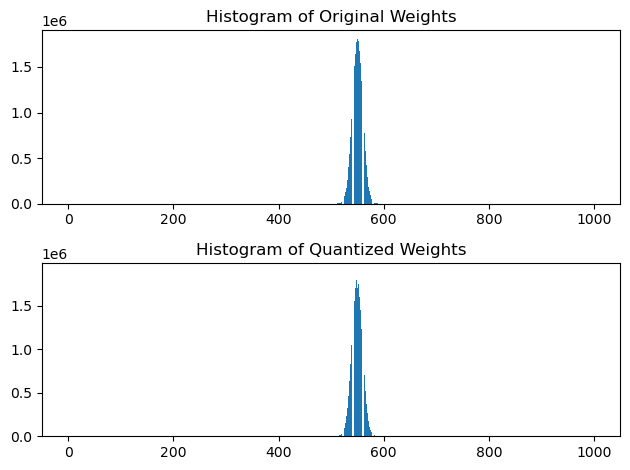

layers.1.mlp
Linear(in_features=4096, out_features=11008, bias=False)


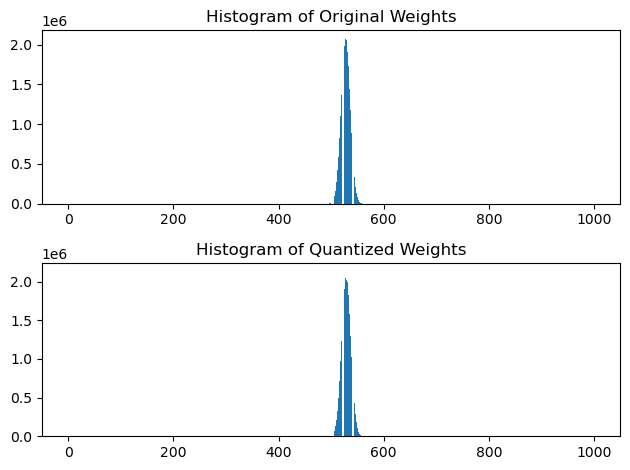

layers.2.mlp
Linear(in_features=4096, out_features=11008, bias=False)


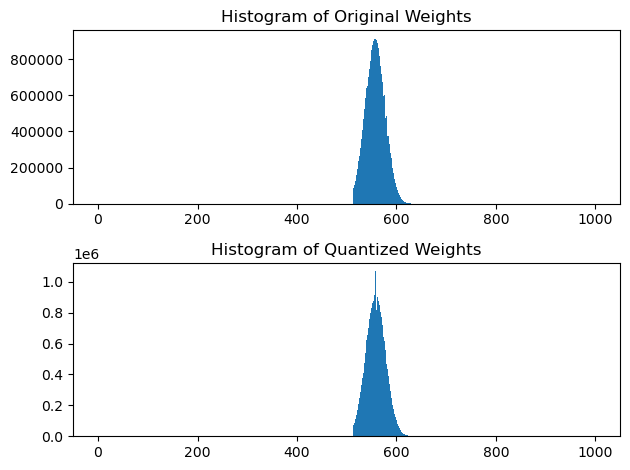

layers.3.mlp
Linear(in_features=4096, out_features=11008, bias=False)


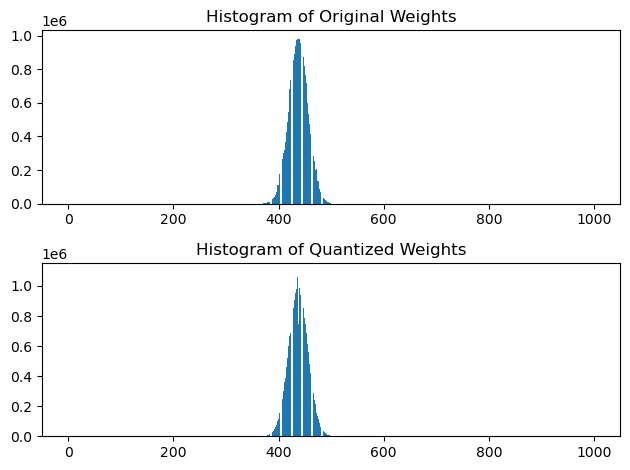

layers.4.mlp
Linear(in_features=4096, out_features=11008, bias=False)


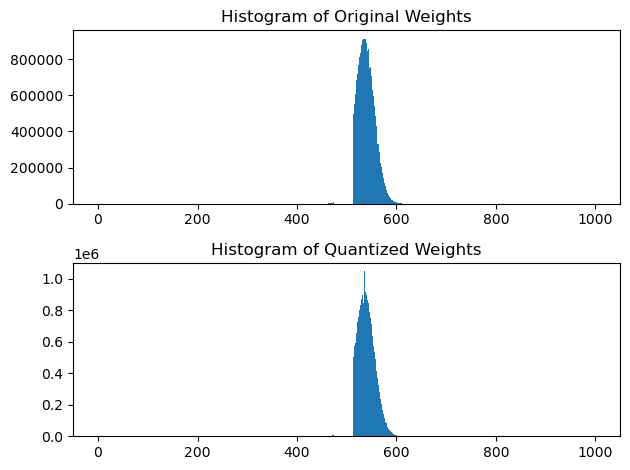

layers.5.mlp
Linear(in_features=4096, out_features=11008, bias=False)


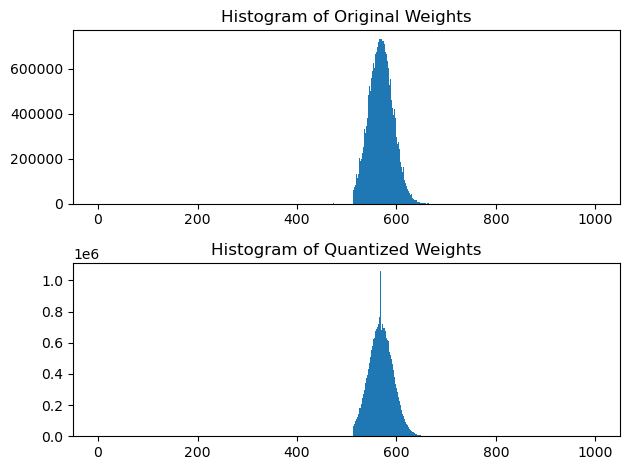

layers.6.mlp
Linear(in_features=4096, out_features=11008, bias=False)


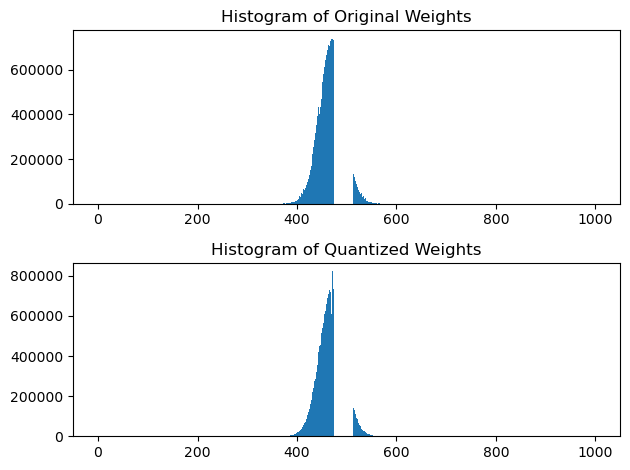

layers.7.mlp
Linear(in_features=4096, out_features=11008, bias=False)


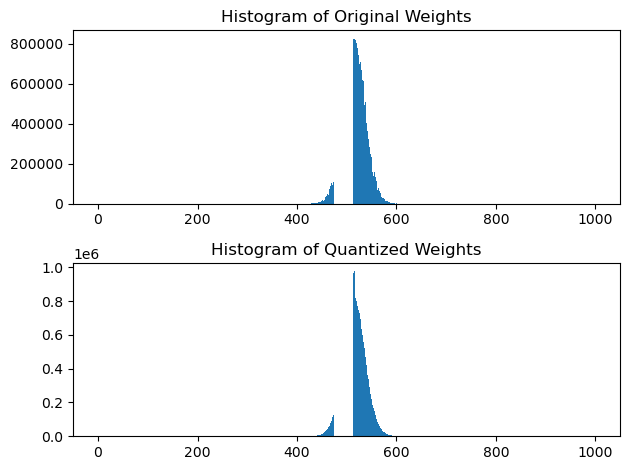

layers.8.mlp
Linear(in_features=4096, out_features=11008, bias=False)


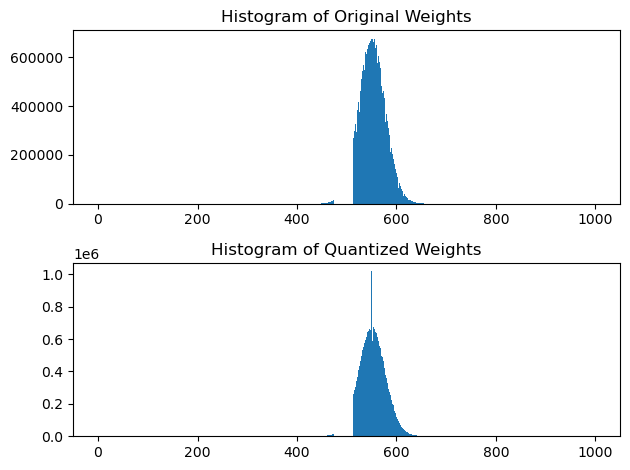

layers.9.mlp
Linear(in_features=4096, out_features=11008, bias=False)


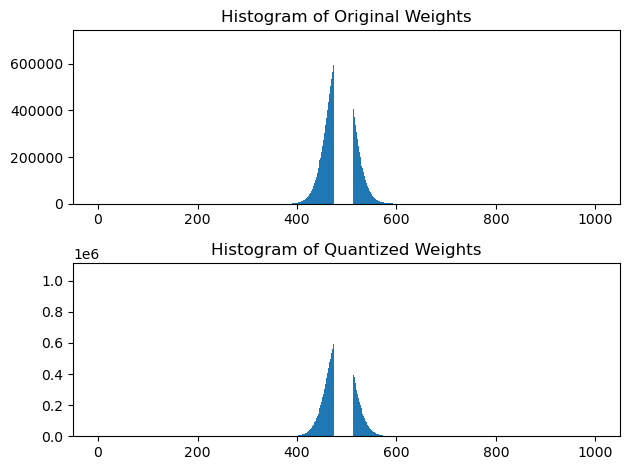

layers.10.mlp
Linear(in_features=4096, out_features=11008, bias=False)


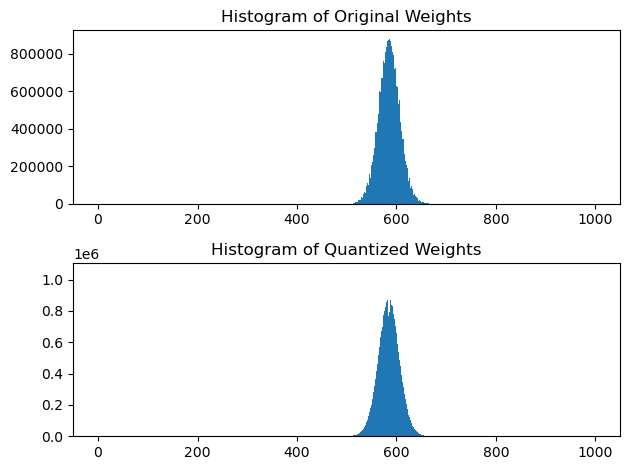

layers.11.mlp
Linear(in_features=4096, out_features=11008, bias=False)


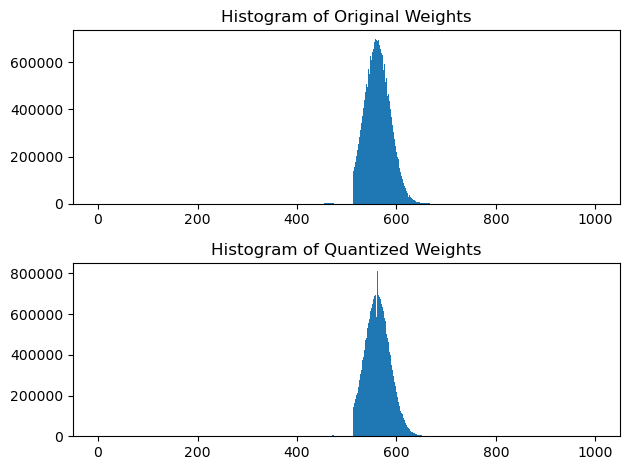

layers.12.mlp
Linear(in_features=4096, out_features=11008, bias=False)


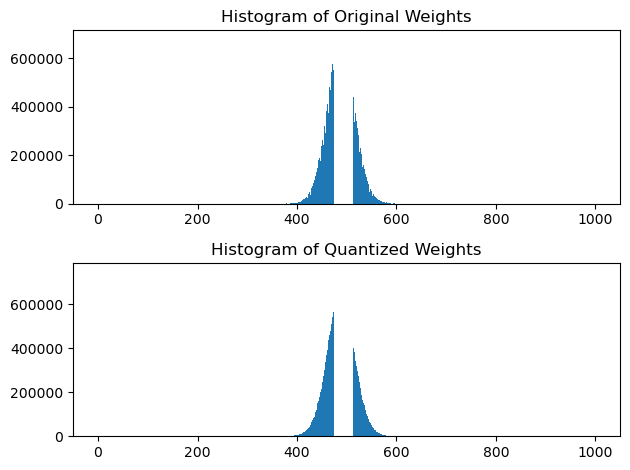

layers.13.mlp
Linear(in_features=4096, out_features=11008, bias=False)


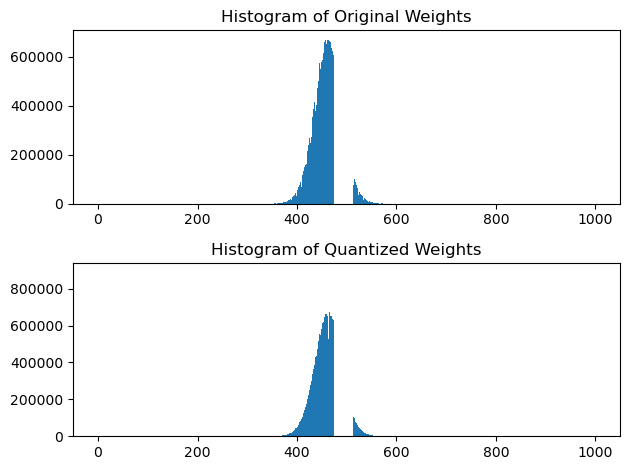

layers.14.mlp
Linear(in_features=4096, out_features=11008, bias=False)


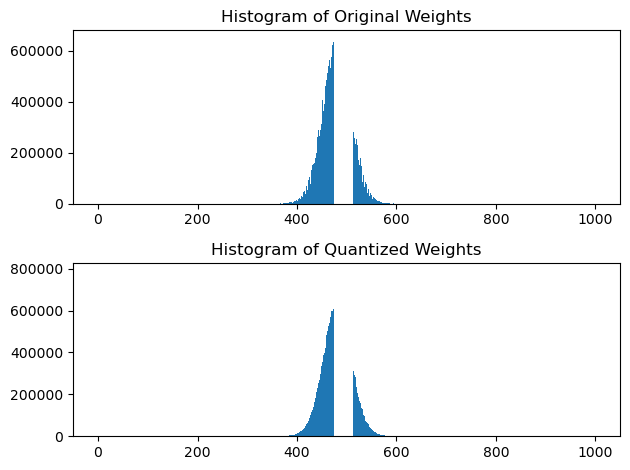

layers.15.mlp
Linear(in_features=4096, out_features=11008, bias=False)


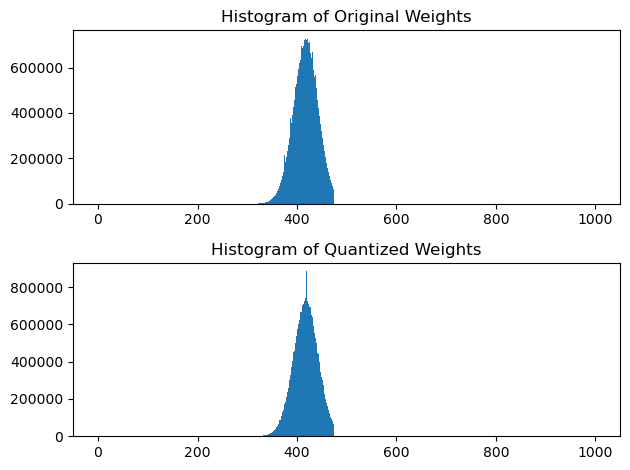

layers.16.mlp
Linear(in_features=4096, out_features=11008, bias=False)


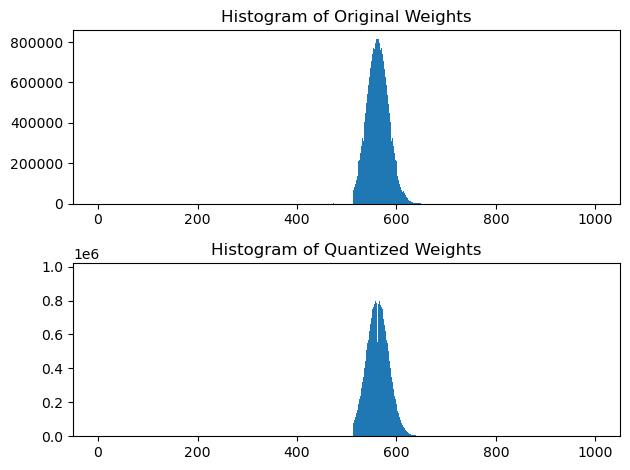

layers.17.mlp
Linear(in_features=4096, out_features=11008, bias=False)


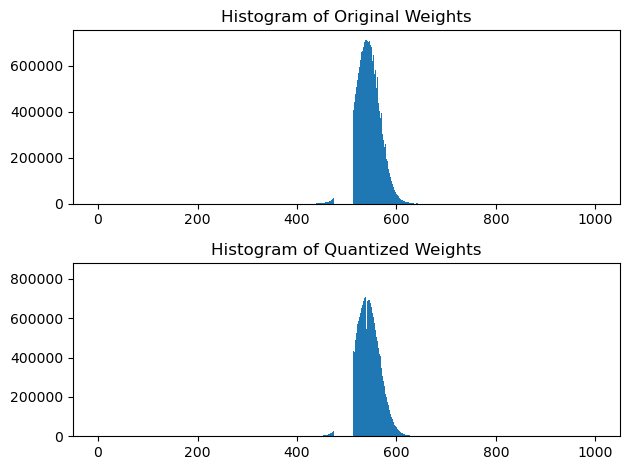

layers.18.mlp
Linear(in_features=4096, out_features=11008, bias=False)


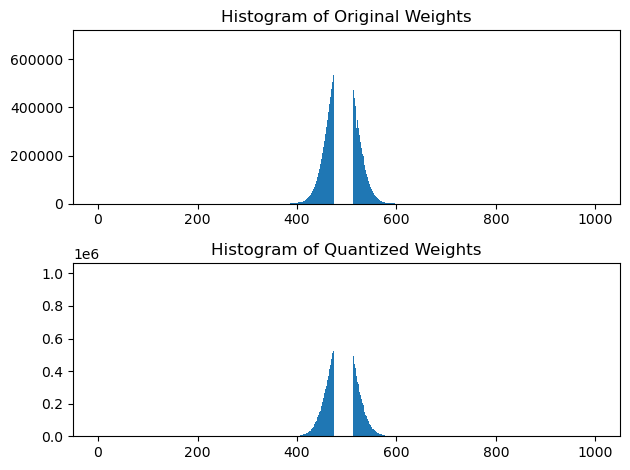

layers.19.mlp
Linear(in_features=4096, out_features=11008, bias=False)


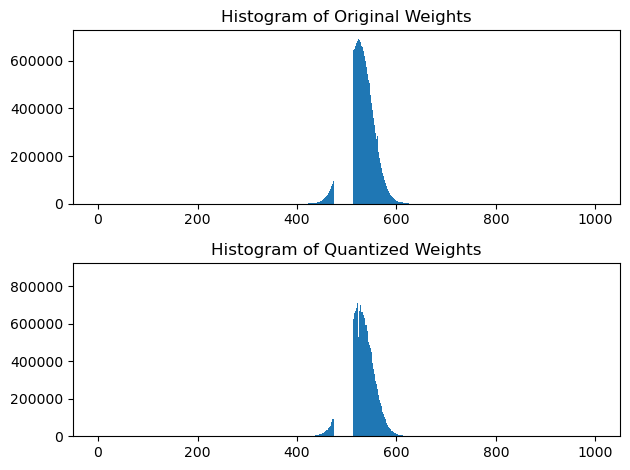

layers.20.mlp
Linear(in_features=4096, out_features=11008, bias=False)


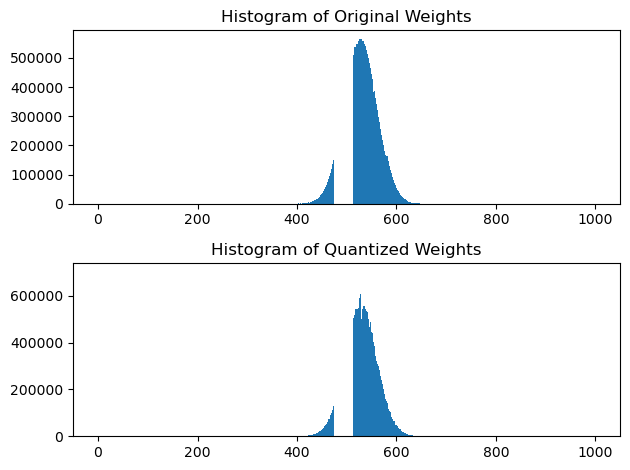

layers.21.mlp
Linear(in_features=4096, out_features=11008, bias=False)


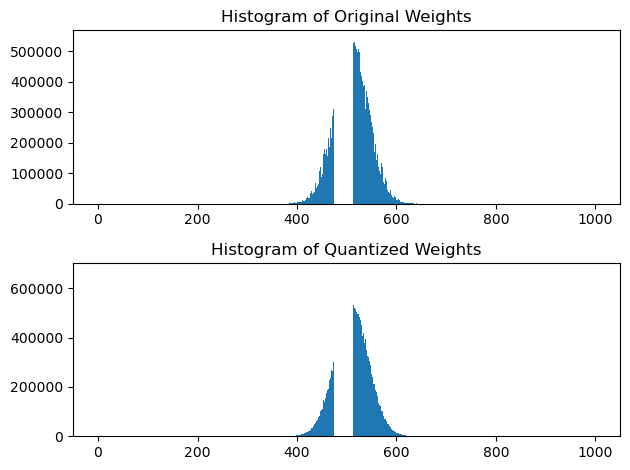

layers.22.mlp
Linear(in_features=4096, out_features=11008, bias=False)


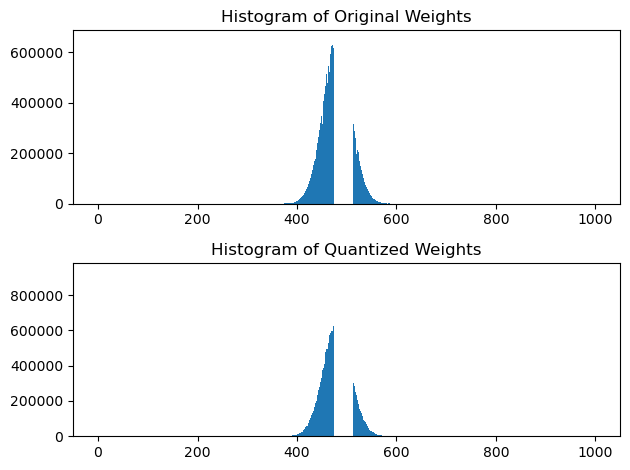

layers.23.mlp
Linear(in_features=4096, out_features=11008, bias=False)


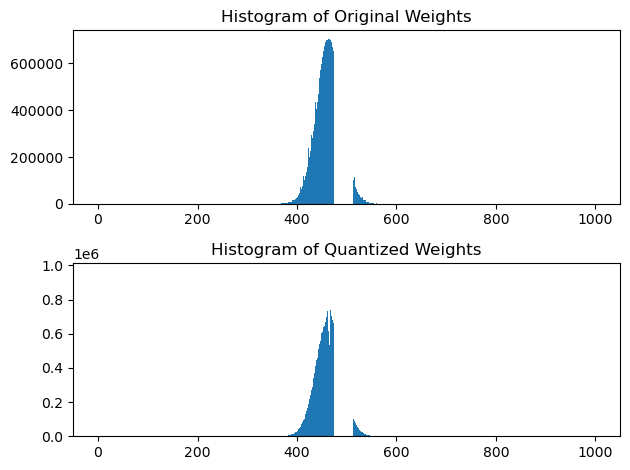

layers.24.mlp
Linear(in_features=4096, out_features=11008, bias=False)


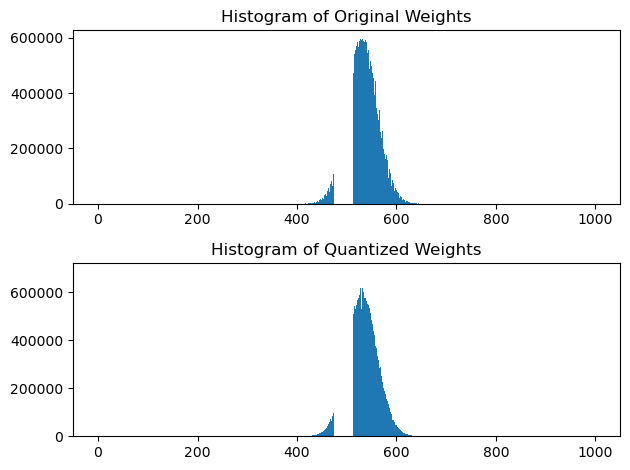

layers.25.mlp
Linear(in_features=4096, out_features=11008, bias=False)


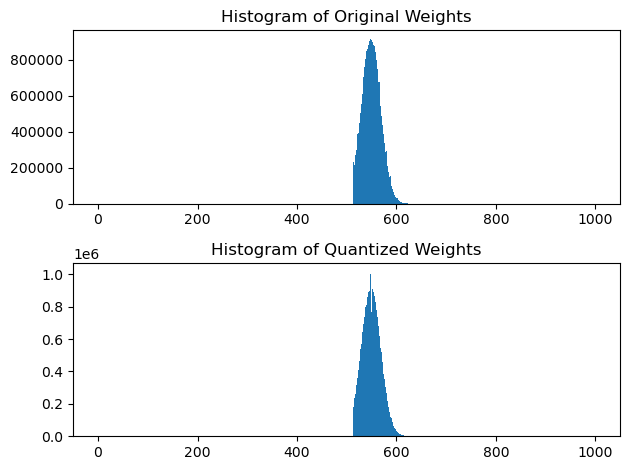

layers.26.mlp
Linear(in_features=4096, out_features=11008, bias=False)


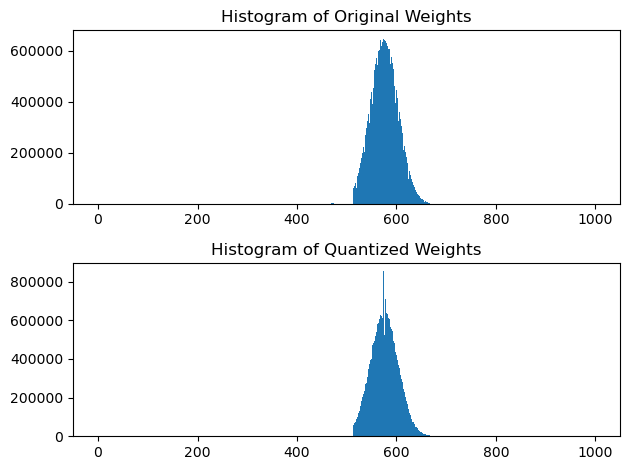

layers.27.mlp
Linear(in_features=4096, out_features=11008, bias=False)


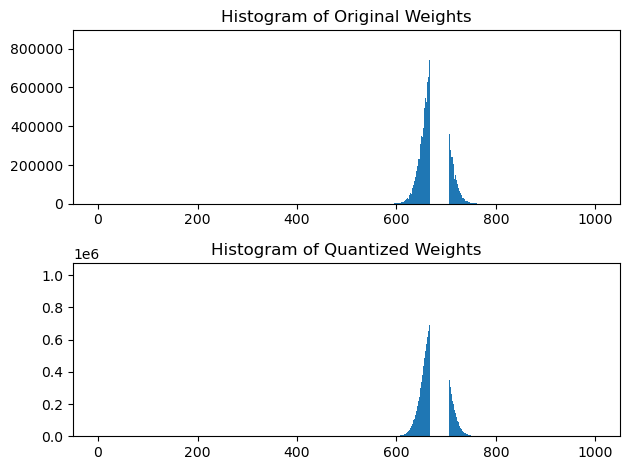

layers.28.mlp
Linear(in_features=4096, out_features=11008, bias=False)


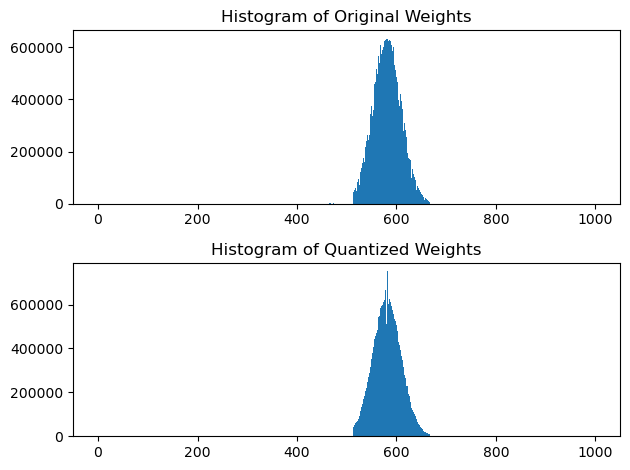

layers.29.mlp
Linear(in_features=4096, out_features=11008, bias=False)


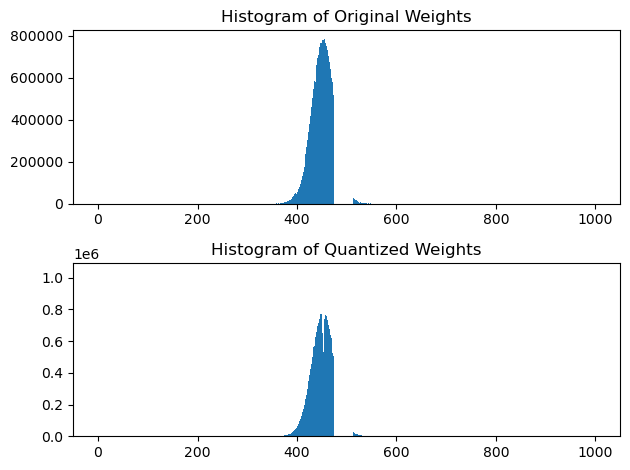

layers.30.mlp
Linear(in_features=4096, out_features=11008, bias=False)


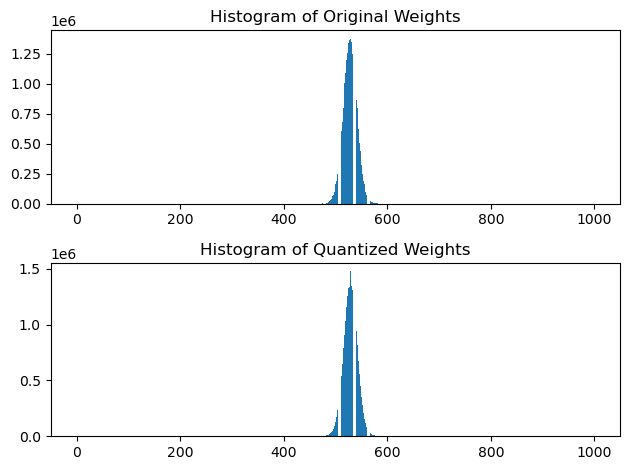

layers.31.mlp
Linear(in_features=4096, out_features=11008, bias=False)


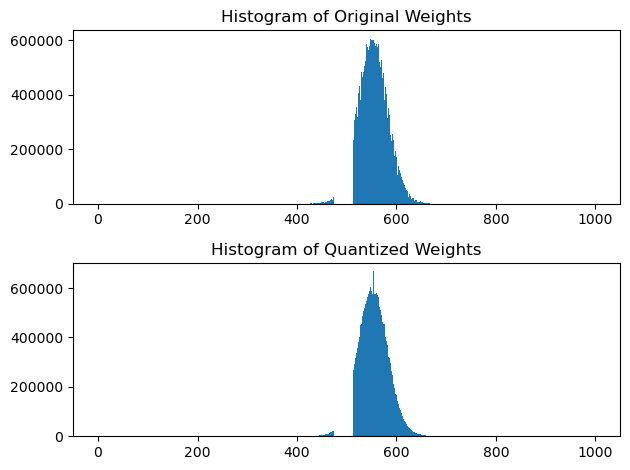

In [5]:
import matplotlib.pyplot as plt
from transformers.models.llama.modeling_llama import LlamaAttention, LlamaMLP
import numpy as np
from smoothquant.fake_quant import quantize_weight_per_channel_absmax


for name, m in model_fp16.model.named_modules():
    # print(name)
    # if isinstance(m, LlamaAttention):
    #     # Her we simulate quantizing BMM inputs by quantizing the output of q_proj, k_proj, v_proj
    #     # print(m.q_proj)
    #     # print(m.k_proj)
    #     # print(m.v_proj)
    #     # print(m.o_proj)
        
    if isinstance(m, LlamaMLP):
        print(name)
        print(m.gate_proj)
        fig, axs = plt.subplots(2)

        # Plot histogram of original weights
        hist = torch.histc(m.gate_proj.weight.float(), bins=1000)
        axs[0].bar(range(1000), hist.cpu().detach().numpy())
        axs[0].set_title('Histogram of Original Weights')

        # Quantize weights and plot histogram
        new_weight = quantize_weight_per_channel_absmax(m.gate_proj.weight, n_bits=8)
        hist = torch.histc(new_weight.float(), bins=1000)
        axs[1].bar(range(1000), hist.cpu().detach().numpy())
        axs[1].set_title('Histogram of Quantized Weights')

        # Display the figure with subplots
        plt.tight_layout()
        plt.show()
        
        # print(m.up_proj)

        # print(m.down_proj)

## Naive W8A8 Quantized Model Perplexity

In [ ]:
model_w8a8 = quantize_llama_like(model_fp16, bits=(4,8))
print(model_w8a8)

In [ ]:
ppl_w8a8 = evaluator.evaluate(model_w8a8)
print(f"Naive W8A8 quantized model perplexity: {ppl_w8a8}")

We can see there is a perplexity increase. We then use SmoothQuant to quantize the model and check the performance.

## SmoothQuant W8A8 Quantized Model Perplexity

In [ ]:
model = LlamaForCausalLM.from_pretrained(
    "/workspace/meta-llama/Llama-2-7b", torch_dtype=torch.float16, device_map="auto"
)
act_scales = torch.load("../act_scales/llama-2-7b.pt")
smooth_lm(model, act_scales, 0.85)
model_smoothquant_w8a8 = quantize_llama_like(model, bits=(8,8))
print(model_smoothquant_w8a8)

We can see the smoothed model has a lower perplexity which is close to the FP16 model's. This is because SmoothQuant smooths the outliers in activations and balances the quantization difficulty of activations and weights.

In [ ]:
ppl_smoothquant_w8a8 = evaluator.evaluate(model_smoothquant_w8a8)
print(f"SmoothQuant W8A8 quantized model perplexity: {ppl_smoothquant_w8a8}")